<a style="center;" href="https://www.sorbonne-universite.fr/"><img style="height:120px;" src="https://upload.wikimedia.org/wikipedia/fr/c/cd/Logo_Sorbonne_Universit%C3%A9.png"/></a>

$ $ 

# $$ \text{Introduction LBM sur Réseau - MU5MEF13} $$

$$ \textit{Abouakil Majda} - \textit{Canet Noémie} - {Duvivier Valentin} - \textit{Jing Yuyao} - \textit{Wang Jyayu} - MF2A/CompMech $$

$ $ 

$ $ 

$\underline{Abstract}$ : Ce rapport fait partie du TP du cours 'Simulation numérique haute fidélité pour les écoulements turbulents'.

Il a pour objectif l'étude d'un tourbillon convecté, dans le but d'en étudier la dynamique et la stabilité en fonction de certains paramètres.

Il a été conduit par les 5 étudiants listés ci-dessus, et nous confirmons donc qu'aucune partie du document qui suit n'a été plagiée d'aucune façon.

---

#### Introduction TP

Le tourbillon qui est l'objet de notre étude est initialisé via la fonction suivante :

$$
\left \{
\begin{array}{rcl}
\displaystyle{u_x} &= &\displaystyle{U_\infty-\dfrac{\epsilon U_0}{r_0}(y-y_0)\exp\left 
[\dfrac{1}{2}\left(1-\dfrac{r^2}{r_0^2} \right) \right]}\\[0.3cm]
\displaystyle{u_y} &= &\displaystyle{\dfrac{\epsilon U_0}{r_0}(x-x_0)\exp\left 
[\dfrac{1}{2}\left(1-\dfrac{r^2}{r_0^2} \right) \right]}\\[0.3cm]
\end{array}~~~~~~~
\right.
$$

Avec $r^2=(x-x_0)^2+(y-y_0)^2$, $\epsilon=0.1$ et $r_0=20$ le rayon du tourbillon.

Nous allons étudier le comportement dynamique de ce système par résolution des équations de la LBM à l'ordre 2, soit donc N-S.

$\underline{\text{Domaine}}:$
Le tourbillon évolue dans le domaine 2D $(x,y)=[0,400]\times[0,400]$, tandis qu'il est défini par $r_0=20$ et se situe initialement en $(x_0, y_0)=(200,200)$, soit au centre du domaine.

$\underline{\text{Propriétés du fluide}}:$
L'écoulement est subsonique, avec $Ma=0.2$ mais reste légèrement $\textbf{compressible}$. Nous utiliserons ce point pour l'étude du mouvement du tourbillon et de sa baisse d'amplitude au cours du temps.

$\underline{\text{Discrétisation en espace}}:$
On utilise 9 composantes de vitesses pour décrire les moments (i.e. D2Q9). A celles-ci s'ajoutent différents poids $\omega_a$, quantifiant l'importance de chaque terme dans la résolution.

Avec ces éléments en main, la résolution de la LBM se traduit par une résolution des équations suivantes:


* perturbation de l'état d'équilibre $$g_{\alpha}^{coll} = g_{\alpha}-\dfrac{1}{\tau_g}[g_{\alpha}-g_{\alpha}^{eq}]$$


* propagation de l'information $$g_{\alpha}(x,y) = g_{\alpha}^{coll}(x-c_{\alpha,x},y-c_{\alpha,y})$$


* application des BCs périodiques, parfaites [1]


* calcul des moments

|Moments|test|test|
|:-----:|:--:|:--:|
| $\rho$ |$=$ | $\sum_1^9$ $g_{\alpha}$|
| $\rho.u_x$ |$=$ | $\sum_1^9$ $c_{\alpha,x}$.$g_{\alpha}$|
| $\rho.u_y$ |$=$ | $\sum_1^9$ $c_{\alpha,y}$.$g_{\alpha}$|

* équilibre $$\displaystyle{g_{\alpha}^{eq}=\rho\omega_\alpha\left(1+\dfrac{c_{\alpha,i}u_i}{c_0^2}+\dfrac{(c_{\alpha,i}u_i)^2}{2c_0^4}-\dfrac{u_i^2}{2c_0^2}\right)}$$

---

#### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

#Pour pouvoir afficher les figures dans le Notebook
%matplotlib inline

#### Data

In [2]:
# Parametres du modele D2Q9
nx = ny = 400

# vitesses discrètes
ca= np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]]) 

def ParaMod(_nx,_ny):
    
    global cax, cay, w, Xi, Yi, Zi
    
    cax = np.zeros((9,nx,ny), dtype=int)
    cax[6,:,:] = cax[3,:,:] = cax[7,:,:] = -1
    cax[5,:,:] = cax[1,:,:] = cax[8,:,:] = 1

    cay = np.zeros((9,nx,ny), dtype=int)
    cay[8,:,:] = cay[4,:,:] = cay[7,:,:] = -1
    cay[5,:,:] = cay[2,:,:] = cay[6,:,:] = 1

    w = np.zeros((9,nx,ny))
    w[0,:,:] = 4/9
    w[1:5,:,:] = 1/9
    w[5:,:,:] = 1/36

    Xi,Yi,Zi=np.meshgrid(np.arange(9),np.arange(nx),np.arange(ny))
    Xi = np.transpose(Xi, (1, 0, 2))
    Yi = np.transpose(Yi, (1, 0, 2))
    Zi = np.transpose(Zi, (1, 0, 2))
    
    Yi = Yi - cax
    Zi = Zi - cay
    Yi[Yi>=nx] = 0
    Zi[Zi>=ny] = 0

c0=1/3**0.5# coefficient de vitesse du son

M0 = 0.2
R0 = 20
taug=0.5# a définir

ParaMod(nx,ny)

#### Algorithme LBM

In [3]:
def init(M0,R0,theta=0):
    
    """ Function returning macro variables
    and equilibrium function.
    """
    
    # Mesh
    X,  Y  = np.meshgrid(np.arange(nx),np.arange(ny))
    x0, y0 = int(nx/2), int(ny/2)
    
    X = (X - x0).T
    Y = (Y - y0).T
    
    x0 = 0
    y0 = 0
    
    # -----
    # Paramètres tourbillon

    epsilon = 0.1
    
    U0  = M0/np.sqrt(3.)
    R   = np.sqrt((X-x0)**2 + (Y-y0)**2)
    rho = np.ones((nx,ny))
    
    # speed swirl
    ux  = U0 - epsilon*U0/R0 * (Y-y0) * np.exp(.5 * (1 - (R/R0)**2))
    uy  =      epsilon*U0/R0 * (X-x0) * np.exp(.5 * (1 - (R/R0)**2))
    
    geq = np.zeros((9, nx, ny))
    eq(geq, rho, ux, uy)
    
    return geq, rho, ux, uy

# -----
    
def collide(gcoll, g, geq, taug):
    
    """ Function returning 
    collision state.
    """
    
    gcoll[:,:,:] =  g[:,:,:] - 1./taug * (g[:,:,:] - geq[:,:,:])
    
def propagate(g,gcoll):
    
    """ Function returning 
    propagation function.
    """
    
    # interior points only
    g[:,:,:]= gcoll[Xi,Yi,Zi]
    
# -----

def macro(g, rho, ux, uy):
    
    """ Function returning 
    macro variables.
    """

    # calcul des variables macro    
    rho[:,:] = np.sum(g,axis=0)
    
    ux[:,:] = np.sum(g*cax,axis=0)
    ux[:,:] = ux[:,:]/rho[:,:]
    
    uy[:,:] = np.sum(g*cay,axis=0)
    uy[:,:] = uy[:,:]/rho[:,:]

# -----

def eq(geq, rho, ux, uy):
    
    """ Function returning 
    equilibrium function.
    """
    
    geq[:,:,:] = (rho*w*(1 + (cax*ux+cay*uy)   /   c0**2  +\
                             (cax*ux+cay*uy)**2/(2*c0**4) -\
                             (ux**2+uy**2)/(2*c0**2)))[:,:,:]
    
def boundary(g, gcoll):
    
    """ Function applying periodic
    perfect boundary conditions.
    """
    
    # Entree
    g[1,0,:  ]  = gcoll[1,-1,:  ]
    g[5,0,1: ]  = gcoll[5,-1,:-1]
    g[8,0,:-1]  = gcoll[8,-1,1: ]
    
    # Sortie
    g[3,-1,:  ] = gcoll[3,0,:  ]
    g[6,-1,:-1] = gcoll[6,0,1: ]
    g[7,-1,1: ] = gcoll[7,0,:-1]
    
    # Bas
    g[2,:  ,0]  = gcoll[2,:  ,-1]
    g[5,:-1,0]  = gcoll[5,1: ,-1]
    g[6,1: ,0]  = gcoll[6,:-1,-1]
    
    # Haut
    g[4,:  ,-1] = gcoll[4,:  ,0]
    g[7,:-1,-1] = gcoll[7,1: ,0]
    g[8,1: ,-1] = gcoll[8,:-1,0]

    # Coins
    g[5, 0, 0]  = gcoll[5,-1,-1]
    g[6,-1, 0]  = gcoll[6, 0,-1]
    g[7,-1,-1]  = gcoll[7, 0, 0]
    g[8, 0,-1]  = gcoll[8,-1, 0]

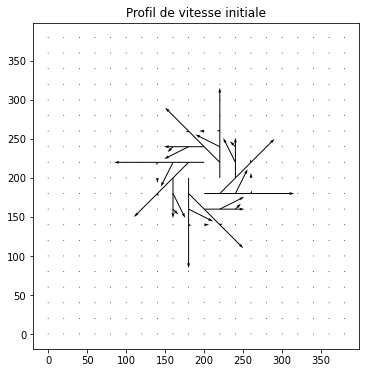

In [4]:
geq,rho,ux,uy=init(M0,R0)

fig, ax = plt.subplots(figsize=(6,6))
X,Y=np.meshgrid(np.arange(nx),np.arange(ny))
ax.set_aspect('equal')
ax.quiver(X[::20,::20],Y[::20,::20],ux[::20,::20].T-M0/np.sqrt(3.),uy[::20,::20].T,units='xy',scale = 1.e-4,scale_units='xy')
ax.set_title('Profil de vitesse initiale')

plt.show()

#### Résolution LBM

In [18]:
# Nombre d'iterations:
nt = 10

# initialisation
geq, rho, ux, uy = init(M0,R0)
g, gcoll = geq.copy(),geq.copy()

# -----

start=time.time()
for t in range(nt):
    collide(gcoll, g, geq, taug) # Collision
    propagate(g, gcoll)          # Propagation
    boundary(g, gcoll)           # BCs
    macro(g, rho, ux, uy)        # Calcul moments
    eq(geq, rho, ux, uy)         # Calcul equilibre

tcal=time.time()-start
print("Temps de calcul: "+str(tcal)+" s")

Temps de calcul: 6.5589659214019775 s


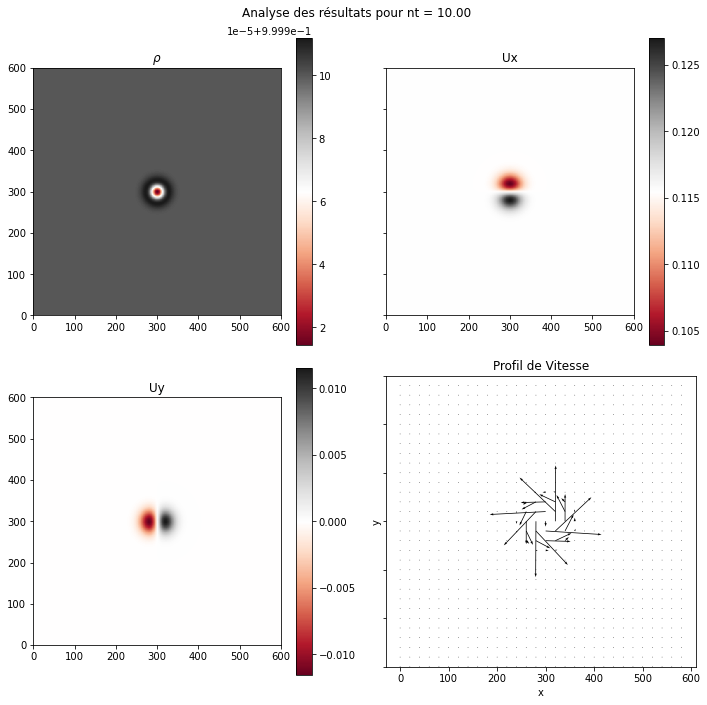

In [20]:
def plot_fin(rho, ux, uy):
    
    """ Function ploting some initialized data.
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(10,10), sharey=True)
    fig.suptitle("Analyse des résultats pour nt = %0.2f"%nt)
    axs[0,0].set_aspect(1)
    pcm = axs[0,0].pcolormesh(rho.T,cmap='RdGy')
    fig.colorbar(pcm, ax=axs[0,0])
    
    axs[0,0].set_title(r'$\rho$')
    axs[1,1].set_xlabel('x')
    axs[1,1].set_ylabel('y')
    
    # ---
    
    axs[0,1].set_aspect(1)
    pcm = axs[0,1].pcolormesh(ux.T,cmap='RdGy')
    fig.colorbar(pcm, ax=axs[0,1])

    axs[0,1].set_title('Ux')
    axs[1,1].set_xlabel('x')
    axs[1,1].set_ylabel('y')
    
    # ---
    
    axs[1,0].set_aspect(1)
    pcm = axs[1,0].pcolormesh(uy.T,cmap='RdGy')
    fig.colorbar(pcm, ax=axs[1,0])

    axs[1,0].set_title('Uy')
    axs[1,1].set_xlabel('x')
    axs[1,1].set_ylabel('y')

    # ---
    
    axs[1,1].set_aspect(1)
    X,Y=np.meshgrid(np.arange(nx),np.arange(ny))
    axs[1,1].quiver(X[::20,::20],Y[::20,::20],ux[::20,::20].T-M0/np.sqrt(3.),uy[::20,::20].T,units='xy',scale = 1.e-4,scale_units='xy')

    axs[1,1].set_title('Profil de Vitesse')
    axs[1,1].set_xlabel('x')
    axs[1,1].set_ylabel('y')

    # -----
    
    plt.tight_layout()
    
# ---
    
plot_fin(rho, ux, uy)

**Commentaires**

Après convergence des résultats, on est en mesure d'afficher les variables $\rho$, $u_x$, $u_y$ à partir des moments de la méthode LBM.

On observe que la masse volumique est légèrement 𝐜𝐨𝐦𝐩𝐫𝐞𝐬𝐬𝐢𝐛𝐥𝐞. Nous utiliserons ce point pour l'étude du mouvement du tourbillon et de sa baisse d'amplitude au cours du temps.


Nous pouvons observer sur les champs de vitesse le mouvement du tourbillon. Le champ Ux nous indique des vitesse positives en bas et en haut du tourbillon : ce dernier se déplace vers la droite. Le champ Uy indique des vitesses positives en bas du tourbillon et négatives en haut : il tourne sur lui même, et vers la gauche. Ceci est cohérent avec le profil de vitesse (en bas à droite) qui fusionne ces deux résultats.


**Temps de calcul en fonction de la taille du maillage**

In [7]:
def CalculTime():
    
    """ Function returning calculation time
    used to solve syst. with the LBM.
    """
    
    ParaMod(nx,ny)
    
    geq, rho, ux, uy = init(M0, R0)
    g, gcoll=geq.copy(),geq.copy()
    
    x0=int(nx/2)
    y0=int(ny/2)
    
    # ---
    
    start=time.time()
    for t in range(nt):
        collide(gcoll, g, geq, taug) # Collision
        propagate(g, gcoll)          # Propagation
#         boundary(g, gcoll)           # Conditions aux limites domaine
        macro(g, rho, ux, uy)        # Calcul des moments
        eq(geq, rho, ux, uy)         # Calcul de feq
    
    tcal=time.time()-start
    
    return tcal,

In [9]:
NX=[100,150,200,250,300,350,400,600]
Times = []

# Nombre d'iterations:
nt = 60
for nx in NX:
    ny=nx
    tcal = CalculTime()
    Times.append(tcal)

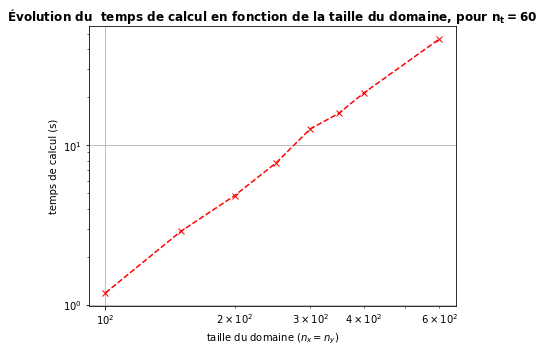

In [12]:
plt.figure(figsize=(6,5))

plt.loglog(NX,Times,'rx--')

plt.title(r'Évolution du  temps de calcul en fonction de la taille du domaine, pour $\mathbf{n_t=}$'+str(nt), fontweight='bold')
plt.xlabel(r'taille du domaine ($n_x=n_y$)')
plt.ylabel('temps de calcul (s)')

plt.grid(True)
plt.tight_layout()

plt.show()

**Commentaires :**

---
La courbe montre que le temps de calcul croît exponentiellement en fonction de la taille du domaine. Après avoir comparé un calcul avec boucle et un calcul sans  boucle, nous avons remarqué que la méthode sans boucle permet de réduire de 50% du temps de calcul. C'est pourquoi nous gardons cette méthode d'algorithme dans ce TP.

--- 

<h2>Analyse des résultats</h2>

**Représentation de la masse volumique $\rho$ et de vitesse à la fin de la simulation:**

In [13]:
# Nombre d'iterations:

def Tourbillon():
    
    """ Function solving flow of swirl
    and returning data saved in some 
    specific location.
    """
    
    ParaMod(nx,ny)
    
    geq, rho, ux, uy=init(M0, R0)
    g, gcoll = geq.copy(), geq.copy()
    
    prof =np.zeros(nt) #profil de vitesse en fonction du temps
    probe=np.zeros((6,nt))
    
    x0=int(nx/2)
    y0=int(ny/2)
    
    # ---
    
    for t in range(nt):
        collide(gcoll, g, geq, taug) # Collision
        propagate(g, gcoll)          # Propagation
        boundary(g, gcoll)           # Conditions aux limites domaine
        macro(g, rho, ux, uy)        # Calcul des moments
        eq(geq, rho, ux, uy)         # Calcul de feq

        # save some data
        probe[0,t] = rho[x0   ,y0   ]
        probe[1,t] = rho[x0+10,y0+10]
        probe[2,t] = ux [x0   ,y0   ]
        probe[3,t] = ux [x0+10,y0+10]
        probe[4,t] = uy [x0   ,y0   ]
        probe[5,t] = uy [x0+10,y0+10]
    
    return probe, rho, ux, uy

In [14]:
def plot_prob(probe):
    
    """ Function ploting pressure across time
    (at a specific location specified in function 
    Tourbillon()).
    """
    
    U0=M0/np.sqrt(3.)
    tstar=np.arange(nt)*U0/nx
    
    # ---
    
    fig, axs = plt.subplots(3, 2, figsize=(16,12))
    
    axs[0,0].plot(tstar,probe[0],'k')
    axs[0,0].set_title(r'$\mathbf{\rho(t^\star)}$ en $\mathbf{(x_0,y_0)}$', fontweight='bold')
#     axs[0,0].set_xlabel(r'$t^\star$',fontsize=18)
    axs[0,0].grid()

    # ---

    axs[0,1].plot(tstar,probe[1],'k')
    axs[0,1].set_title(r'$\mathbf{\rho(t^\star)}$ en $\mathbf{(x_0+10,y_0+10)}$', fontweight='bold')
#     axs[0,1].set_xlabel(r'$t^\star$',fontsize=18)
    axs[0,1].grid()

    # ---

    axs[1,0].plot(tstar,probe[2],'k')
    axs[1,0].set_title(r'$\mathbf{ux(t^\star)}$ en $\mathbf{(x_0,y_0)}$', fontweight='bold')
#     axs[1,0].set_xlabel(r'$t^\star$',fontsize=18)
    axs[1,0].grid()

    # ---

    axs[1,1].plot(tstar,probe[3],'k')
    axs[1,1].set_title(r'$\mathbf{ux(t^\star)}$ en $\mathbf{(x_0+10,y_0+10)}$', fontweight='bold')
#     axs[1,1].set_xlabel(r'$t^\star$',fontsize=18)
    axs[1,1].grid()

    # ---

    axs[2,0].plot(tstar,probe[4],'k')
    axs[2,0].set_title(r'$\mathbf{uy(t^\star)}$ en $\mathbf{(x_0,y_0)}$', fontweight='bold')
    axs[2,0].set_xlabel(r'$t^\star$',fontsize=18)
    axs[2,0].grid()

    # ---

    axs[2,1].plot(tstar,probe[5],'k')
    axs[2,1].set_title(r'$\mathbf{uy(t^\star)}$ en $\mathbf{(x_0+10,y_0+10)}$', fontweight='bold')
    axs[2,1].set_xlabel(r'$t^\star$',fontsize=18)
    axs[2,1].grid()

    plt.tight_layout()


Nous avons d'abord testé avec taug = 0.5, on n'arrive pas à voir le tourbillon passe 5 fois (warning de python nous indique que la valeur est trops grande). La solution diverge. Nous avons ensuite augmenté la valeur de taug à 0.501, mais la solution encore diverge. Avec les analyses sur le taug en bas, nous avons finalement choisi taug = 0.51 pour faire le tourbillon passe 5 passages.

**Représentation de l'évolution de la vitesse et de la masse volumique au centre du domaine en fonction du temps normalisé $t^*=t\dfrac{U_0}{L}$** ($L$ étant ici la largeur du domaine).


In [21]:
nt = 20000
nx = ny = 400
taug = 0.51 #taug>0.5 pour être stable

probe, rho, ux, uy = Tourbillon()

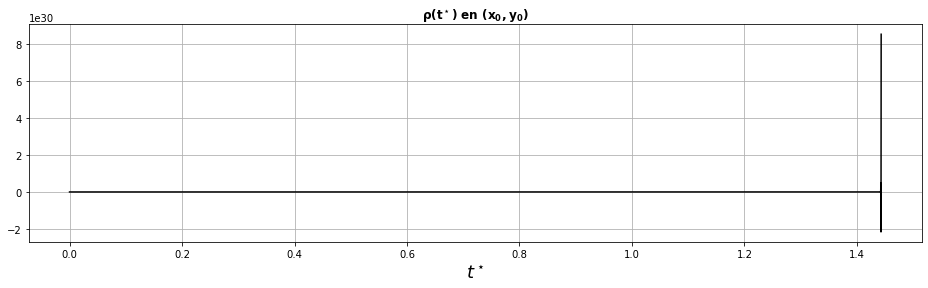

In [22]:
U0    = M0/np.sqrt(3.)
tstar = np.arange(nt)*U0/nx

# ---

fig=plt.figure(figsize=(16,4))

plt.plot(tstar, probe[0],'k')

plt.title(r'$\mathbf{\rho(t^\star)}$ en $\mathbf{(x_0,y_0)}$', fontweight='bold')
plt.xlabel(r'$t^\star$',fontsize=18)

plt.grid(True)

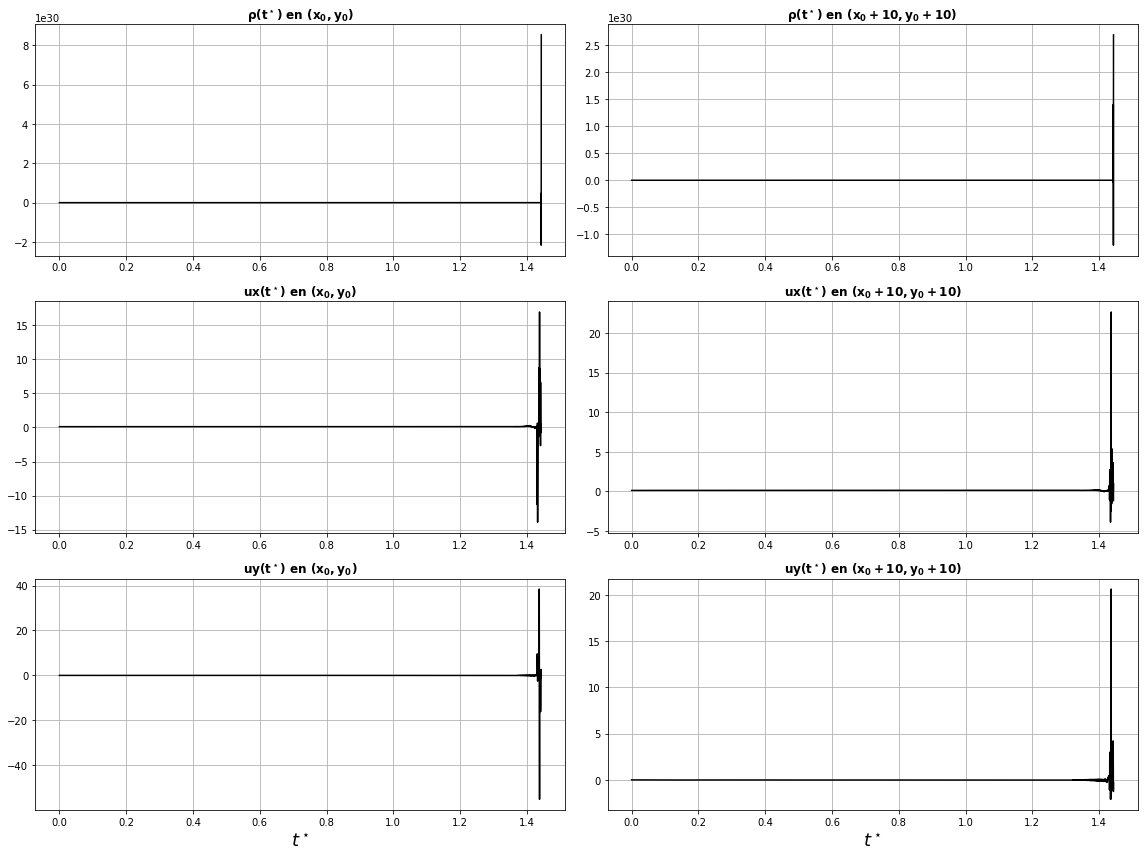

In [23]:
plot_prob(probe)

**Commentaire**

On trace ci-dessus l'évolution de certains $\rho$ locaux, en fonction du temps. En faisant ainsi, on voit que la masse volumique varie au cours du temps, baissant notamment en amplitude. Cette variation traduit une variation de pression car le tourbillon est en mouvement (lien vitesse/pression).

Par ailleurs, il est à noter qu'en fonction du point local choisi, on observe une différence de 'netteté' des variations. L'écoulement variant au cours du temps, il est en effet primordiale de choisir un point du domaine qui va capter des comportements généraux, et non pas des irrégularités locales.

Voyons comment se traduit cette dynamique sur les différents champs.


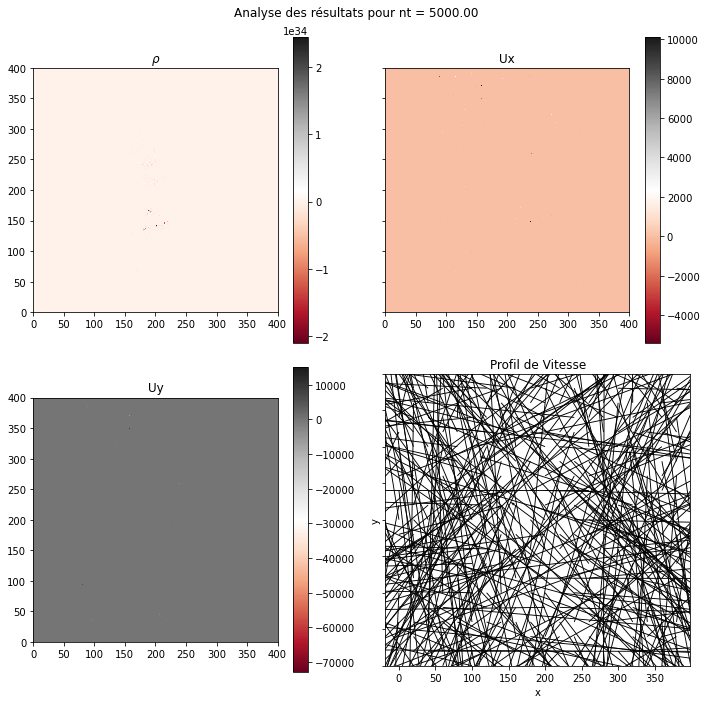

In [24]:
plot_fin(rho, ux, uy)

Nous pouvons voir sur le champ de la masse volumique que celle-ci se dissipe au cours du temps. En effet, sa répartition au temps final (passage de 5 tourbillons) n’est plus homogène comme elle l’était initialement. Cela rappelle l’observation effectuée sur les graphes précédents (rho(t*)), puisque la masse volumique au centre du tourbillon diminue et se dissipe autour de lui.


Tracer l'évolution de la vitesse pour 4 valeurs diffrentes de $\tau_g$: ($0.5,0.501,0.51,0.6$). 

In [ ]:
TAUG = [0.5,0.501,0.51,0.6]
nx, ny = 400, 400
nt=4500
x = np.arange(nx)
y = np.arange(ny)
x0=int(nx/2)
y0=int(ny/2)

fig1, axs = plt.subplots(3, 2, figsize=(16,12))
U0=M0/np.sqrt(3.)
tstar=np.arange(nt)*U0/nx

axs[0,0].set_title(r'$\mathbf{\rho(t^\star)}$ en $\mathbf{(x_0,y_0)}$', fontweight='bold')
# axs[0,0].set_xlabel(r'$t^\star$',fontsize=18)
axs[0,0].grid()


axs[0,1].set_title(r'$\mathbf{\rho(t^\star)}$ en $\mathbf{(x_0+10,y_0+10)}$', fontweight='bold')
# axs[0,1].set_xlabel(r'$t^\star$',fontsize=18)
axs[0,1].grid()


axs[1,0].set_title(r'$\mathbf{ux(t^\star)}$ en $\mathbf{(x_0,y_0)}$', fontweight='bold')
# axs[1,0].set_xlabel(r'$t^\star$',fontsize=18)
axs[1,0].grid()

axs[1,1].set_title(r'$\mathbf{ux(t^\star)}$ en $\mathbf{(x_0+10,y_0+10)}$', fontweight='bold')
# axs[1,1].set_xlabel(r'$t^\star$',fontsize=18)
axs[1,1].grid()


axs[2,0].set_title(r'$\mathbf{uy(t^\star)}$ en $\mathbf{(x_0,y_0)}$', fontweight='bold')
axs[2,0].set_xlabel(r'$t^\star$',fontsize=18)
axs[2,0].grid()


axs[2,1].set_title(r'$\mathbf{uy(t^\star)}$ en $\mathbf{(x_0+10,y_0+10)}$', fontweight='bold')
axs[2,1].set_xlabel(r'$t^\star$',fontsize=18)
axs[2,1].grid()

fig2, axs2 = plt.subplots(figsize=(8,4))
axs2.set_title(r'$\mathbf{ux(x)}$ en $\mathbf{y_0}$', fontweight='bold')
axs2.set_xlabel(r'$x$',fontsize=18)
axs2.grid()


for taug in TAUG :
    probe, rho, ux, uy = Tourbillon()
    axs[0,0].plot(tstar,probe[0],label='$\tau_g$=%.3f'%taug)
    axs[0,1].plot(tstar,probe[1],label='$\tau_g$=%.3f'%taug)
    axs[1,0].plot(tstar,probe[2],label='$\tau_g$=%.3f'%taug)
    axs[1,1].plot(tstar,probe[3],label='$\tau_g$=%.3f'%taug)
    axs[2,0].plot(tstar,probe[4],label='$\tau_g$=%.3f'%taug)
    axs[2,1].plot(tstar,probe[5],label='$\tau_g$=%.3f'%taug)
    
    axs2.plot(x, uy[:,y0],label='$\tau_g$=%.3f'%taug)
#     axs2[1].plot(y, ux[x0,:],label='$\tau_g$=%.3f'%taug)

    
axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[2,0].legend()
axs[2,1].legend()
axs2.legend()
# axs2[1].legend()


plt.show()


**Commentaires:**

Nous traçons l'évolution des différentes avriables en fonction du temps, et on voit bien que avec taug = 0.5, les valeurs des variables explose après certain temps, ce qui est cohérent avec nos observations précédentes. Et on observe aussi que quand taug = 0.6, il y a plus de dissipation. 


# Conclusion

Ce TP a permis de mettre en évidence certaines des forces et faiblesses de la LBM, notamment sa capacité à modéliser fidèlement des écoulements tourbillonaires mais aussi son instabilité dans des cas de faible viscosité.

On a ainsi mis en pratique des méthodes de slicing, Broadcasting de langage Python, pour passer les fonction en version sans boucle.

Des évolution de cette étude sont possibles, comme la prise en compte de conditions aux limites visqueuses, modifiant ainsi la physique du problème.

Par ailleurs, il serait intéressant de caractériser le comportement "général" de l'écoulement par une étude poussé du lien entre compressibilité locale de la masse volumique et nombre de Mach de l'écoulement, complétant l'étude qui vient d'être faite.

<a id="top" style="float:left;" href="http://dynfluid.ensam.eu/"><img style="height:100px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>
<a style="float:right;" href="http://www.cnam.fr//"><img style="height:80px;" src="https://upload.wikimedia.org/wikipedia/commons/6/66/Logo_cnam.gif"/></a>
<center><a href="#top">Retour en haut de la page</a>
<img style="height:50px;" src="https://assets.ensam.eu/logo/fr/logo-trans-322x84.png"/></center>

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')